# Trap Intensity Sensitivity

Finds how the trap site center intensity depends on various parameters such as the spot transmission, relative phase between spots and background, and iris radius.

Another notebook in the series of analysis of Mark's trap array design. 

In [1]:
## general imports
import numpy as np
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift

from scipy.special import j0, j1
from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
from random import random as rand

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions
from physconsts import *

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
imagedir = os.path.join('..','images')
print("images saved in", imagedir)

# for matplotlib labels
fontsize=14

def savefigure(fname):
    filepath = os.path.join(imagedir,fname)
    plt.savefig(filepath, bbox_inches='tight')
    print("saved file to",filepath)

images saved in ..\images


## Spot reflection

No phase difference between disk and background, but check the dependence of the trap depth on spot reflection.

In [3]:
## physics and lens params
# lengths in m

lmbda = 8.05e-7
nu0 = c/lmbda
k = 2*pi/lmbda

f1 = 0.5 # lens focal length
f2 = 0.005
A0 = 1 # input field amplitude

# input mask params
a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum1 = ynum1 = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print("length units are m:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum1}, ynum={ynum1}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

length units are m:
b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046


(-3.141592653589793, 3.141592653589793)

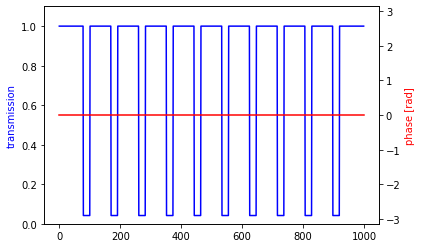

In [5]:
## create a mask that induces a phase difference between spots and background

pts = 1000
phi_std=None # [rad]
pos_std=None
T_aper = 0.082
r_aper = sqrt(1-T) # aperture reflectivity
t_plate = 1 # plate transmissivity
# the mask with desired transmission properties
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T), plate=t_plate)

# spot phase mask.
spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
phi = 0
spot_phases *= exp(-1j*phi)

# mask with 1's on background, 0's on spots.
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

phase_mask = spot_phases + complement

# finally, apply the phases to the transmission mask
field0 = mask*phase_mask

fig,ax1 = plt.subplots()
ax1.plot(range(pts), abs(field0[800,:]),color='blue')
ax1.set_ylabel("transmission",color='blue')
ax1.set_ylim((0,1.1))

ax2 = ax1.twinx()
ax2.plot(range(pts), angle(field0[800,:]),color='red')
ax2.set_ylabel("phase [rad]",color='red')
ax2.set_ylim((-pi,pi))

# plt.imshow(real(conjugate(field0)*field0))

In [31]:
field0[800,:].shape

(1000,)

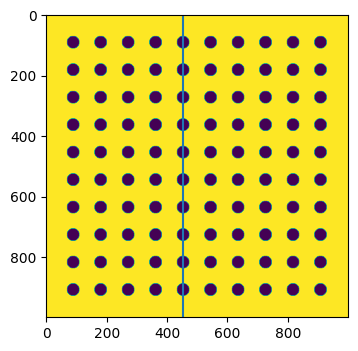

In [6]:
plt.close()
fig,ax = plt.subplots(dpi=100)
plt.imshow(abs(field0))
ax.axvline(453)

In [78]:
linspace(0.05,0.12,7)

array([0.05      , 0.06166667, 0.07333333, 0.085     , 0.09666667,
       0.10833333, 0.12      ])

In [91]:
sqrt(T),1-sqrt(1-T)

(0.34641016151377546, 0.061916848035314054)

In [89]:
# input mask
pts = 1000
phi_std=None # [rad]
pos_std=None

phi = 0
T_aper = 0.082
r_aper = sqrt(1-T) # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

# range of spot phases wrt to background
numsteps = 7
T_steps = linspace(0.05,0.12,numsteps) 
I2max = 1

z2 = f2 # output plane

xslice = 453 # x coordinate of the slice
slices_soln = empty((pts,numsteps),dtype=float) 

for i,T in enumerate(T_steps):

    # calculate the input field
    print(f'T={T}')
    mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T), plate=t_plate)
    
    # add phases to input field 
#     spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
#     spot_phases *= exp(-1j*phi*pi/180)
#     phase_mask = spot_phases + complement

    # finally, apply the phases to the transmission mask
#     field0 = mask*phase_mask
    field0 = mask

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding= int(pts/2) 
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                              logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)
    
#     if phi == 0:
#         I2max = max(abs(field2[:,xslice])**2)
#         print("obtained normalization factor")
    
    slices_soln[:,i] = abs(field2[:,xslice])**2
    print(f"step {i} completed")
    
I2max = max(abs(field2[:,xslice])**2)
for i in range(numsteps):
    slices_soln[:,i] /= I2max

T=0.05
step 0 completed
T=0.06166666666666667
step 1 completed
T=0.07333333333333333
step 2 completed
T=0.08499999999999999
step 3 completed
T=0.09666666666666666
step 4 completed
T=0.10833333333333334
step 5 completed
T=0.12
step 6 completed


In [61]:
[T_steps[i] for i in [1,3,5,7,10]]

[0.08272727272727273,
 0.1741818181818182,
 0.2656363636363636,
 0.35709090909090907,
 0.49427272727272725]

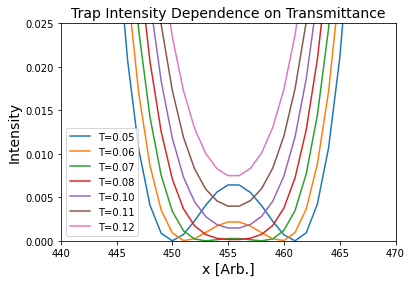

In [90]:
savefig=False
fig,ax = plt.subplots()
for i in range(numsteps):
    ax.plot(range(pts),slices_soln[:,i],label=f'T={T_steps[i]:0.2f}')
ax.set_title("Trap Intensity Dependence on Transmittance",fontsize=fontsize)
ax.set_xlabel("x [Arb.]",fontsize=fontsize)
ax.set_ylabel("Intensity",fontsize=fontsize)
ax.set_ylim((0,0.025))
ax.set_xlim((440,470))
ax.legend()
if savefig:
    fname = f"plot_trap_profile_spot_T_dependence_{int(100*t_plate)}_T_steps_{int(100*T_steps[0])}_{int(100*T_steps[-1])}_{numsteps}pts.png"
    savefigure(fname)

## Spot phases

In [5]:
## physics and lens params
# lengths in m

lmbda = 8.05e-7
nu0 = c/lmbda
k = 2*pi/lmbda

f1 = 0.5 # lens focal length
f2 = 0.005
A0 = 1 # input field amplitude

# input mask params
a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum1 = ynum1 = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print("length units are m:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum1}, ynum={ynum1}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

length units are m:
b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046


(-3.141592653589793, 3.141592653589793)

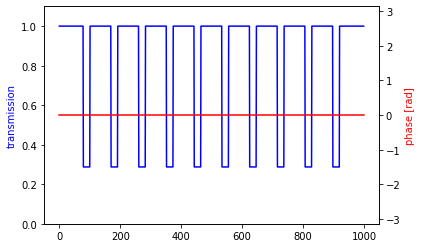

In [6]:
## create a mask that induces a phase difference between spots and background

pts = 1000
phi_std=None # [rad]
pos_std=None
T_aper = 0.0827
r_aper = sqrt(1-T_aper) # aperture reflectivity
t_plate = 1 # plate transmissivity
# the mask with desired transmission properties
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)

# spot phase mask.
spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
phi = 0
spot_phases *= exp(-1j*phi)

# mask with 1's on background, 0's on spots.
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

phase_mask = spot_phases + complement

# finally, apply the phases to the transmission mask
field0 = mask*phase_mask

fig,ax1 = plt.subplots()
ax1.plot(range(pts), abs(field0[800,:]),color='blue')
ax1.set_ylabel("transmission",color='blue')
ax1.set_ylim((0,1.1))

ax2 = ax1.twinx()
ax2.plot(range(pts), angle(field0[800,:]),color='red')
ax2.set_ylabel("phase [rad]",color='red')
ax2.set_ylim((-pi,pi))

# plt.imshow(real(conjugate(field0)*field0))

In [31]:
field0[800,:].shape

(1000,)

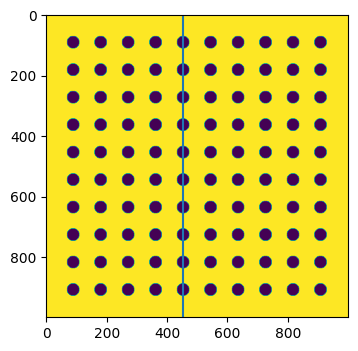

In [6]:
plt.close()
fig,ax = plt.subplots(dpi=100)
plt.imshow(abs(field0))
ax.axvline(453)

In [78]:
linspace(0.05,0.12,7)

array([0.05      , 0.06166667, 0.07333333, 0.085     , 0.09666667,
       0.10833333, 0.12      ])

In [91]:
sqrt(T),1-sqrt(1-T)

(0.34641016151377546, 0.061916848035314054)

In [129]:
# input mask
pts = 1000
phi_std=None # [rad]
pos_std=None

phi = 0
T_aper = 0.0827
r_aper = sqrt(1-T) # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

# range of spot phases wrt to background
numsteps = 5
phi_steps = linspace(0,20,numsteps) 
I2max = 1

z2 = f2 # output plane

xslice = 453 # x coordinate of the slice
slices_soln = empty((pts,numsteps),dtype=float) 

for i,phi in enumerate(phi_steps):

    # calculate the input field
    print(f'phi={phi}')
    mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
    
#     add phases to input field 
    spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
    spot_phases *= exp(-1j*phi*pi/180)
    phase_mask = spot_phases + complement

#     finally, apply the phases to the transmission mask
    field0 = mask*phase_mask
#     field0 = mask

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding= int(pts/2) 
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                              logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)
    
    if phi == 0:
        I2max = max(abs(field2[:,xslice])**2)
        print("obtained normalization factor")
    
    slices_soln[:,i] = abs(field2[:,xslice])**2
    print(f"step {i} completed")
    
# I2max = max(abs(field2[:,xslice])**2)
for i in range(numsteps):
    slices_soln[:,i] /= I2max

phi=0.0
obtained normalization factor
step 0 completed
phi=5.0
step 1 completed
phi=10.0
step 2 completed
phi=15.0
step 3 completed
phi=20.0
step 4 completed


saved file to ..\images\plot_trap_profile_spot_t_plate_100_T_aper_8_phi_steps_0_20_5pts.png


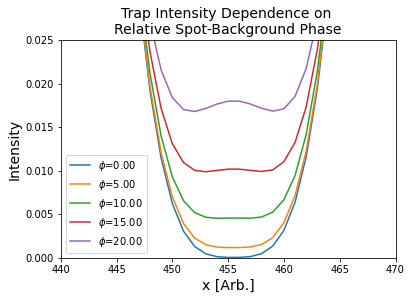

In [133]:
savefig=True
fig,ax = plt.subplots()
for i in range(numsteps):
    ax.plot(range(pts),slices_soln[:,i],label=f'$\phi$={phi_steps[i]:0.2f}')
ax.set_title("Trap Intensity Dependence on \nRelative Spot-Background Phase",fontsize=fontsize)
ax.set_xlabel("x [Arb.]",fontsize=fontsize)
ax.set_ylabel("Intensity",fontsize=fontsize)
ax.set_ylim((0,0.025))
ax.set_xlim((440,470))
ax.legend()
if savefig:
    fname = f"plot_trap_profile_spot_t_plate_{int(100*t_plate)}_T_aper_{int(100*T_aper)}_phi_steps_{int(phi_steps[0]/pi)}_{int(phi_steps[-1])}_{numsteps}pts.png"
    savefigure(fname)

In [101]:
f"plot_trap_min_vs_spot_phase_tplate{int(100*t_plate)}_rspot{int(100*(1-r_aper))}_{numsteps}pts.png"

'plot_trap_min_vs_spot_phase_tplate80_rspot25_101pts.png'

ValueError: x and y must have same first dimension, but have shapes (3,) and (5,)

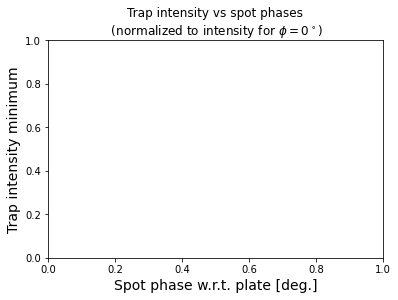

In [134]:
savefig=False
fig,ax = plt.subplots()
ax.set_title(r"Trap intensity vs spot phases" + "\n (normalized to intensity for $\phi=0^\circ$)" )
ax.set_xlabel("Spot phase w.r.t. plate [deg.]",fontsize=fontsize)
ax.set_ylabel(r"Trap intensity minimum",fontsize=fontsize)
ax.plot(phase_steps, [slices_soln[455,i] for i in range(numsteps)],color='crimson')
if savefig:
    fname = f"plot_trap_min_vs_spot_phase_tplate{int(100*t_plate)}_rspot{int(100*(1-r_aper))}_pi{abs(int(phase_steps[0]))}_pf{abs(int(phase_steps[-1]))}_{numsteps}pts.png"
    savefigure(fname)

## Iris radius

In [138]:
## physics and lens params
# lengths in m

lmbda = 8.05e-7
nu0 = c/lmbda
k = 2*pi/lmbda

f1 = 0.5 # lens focal length
f2 = 0.005
A0 = 1 # input field amplitude

# input mask params
a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum1 = ynum1 = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda
zTalboty = 2*Ly2**2/lmbda

## print out parameters
print("length units are m:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum1}, ynum={ynum1}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

length units are m:
b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046


(-3.141592653589793, 3.141592653589793)

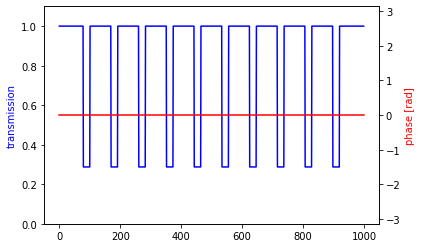

In [16]:
## create a mask that induces a phase difference between spots and background

pts = 1000
phi_std=None # [rad]
pos_std=None
T_aper = 0.0827
r_aper = sqrt(1-T_aper) # aperture reflectivity
t_plate = 1 # plate transmissivity
# the mask with desired transmission properties
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)

# spot phase mask.
spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
phi = 0
spot_phases *= exp(-1j*phi)

# mask with 1's on background, 0's on spots.
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

phase_mask = spot_phases + complement

# finally, apply the phases to the transmission mask
field0 = mask*phase_mask

fig,ax1 = plt.subplots()
ax1.plot(range(pts), abs(field0[800,:]),color='blue')
ax1.set_ylabel("transmission",color='blue')
ax1.set_ylim((0,1.1))

ax2 = ax1.twinx()
ax2.plot(range(pts), angle(field0[800,:]),color='red')
ax2.set_ylabel("phase [rad]",color='red')
ax2.set_ylim((-pi,pi))

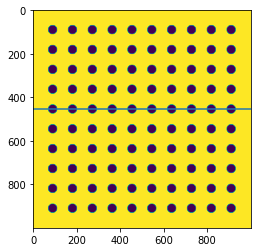

In [21]:
plt.imshow(real(conjugate(field0)*field0))
plt.axhline(xslice)

In [162]:
# input mask
pts = 1000
phi_std=None # [rad]
pos_std=None

phi = 0
T_aper = 0.49 # a far from optimal reflectivity value
r_aper = sqrt(1-T) # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

# range of spot phases wrt to background
numsteps = 21
b_steps = linspace(0.5*b,1.5*b,numsteps) 
I2max = 1

z2 = f2 # output plane

xslice = 453 # x coordinate of the slice
slices_soln = empty((pts,numsteps),dtype=float) 

for i,bs in enumerate(b_steps):

    # calculate the input field
    print(f'b={bs*1e3}mm')
    mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
    
#     add phases to input field 
#     spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
#     spot_phases *= exp(-1j*phi*pi/180)
#     phase_mask = spot_phases + complement

#     finally, apply the phases to the transmission mask
#     field0 = mask*phase_mask
    field0 = mask

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding= int(pts/2) 
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,bs,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                              logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2,field1,bs,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)
    
    if bs == b:
        I2max = max(abs(field2[:,xslice])**2)
        print("obtained normalization factor")
    
    slices_soln[:,i] = abs(field2[:,xslice])**2
    print(f"step {i} completed")
    
I2max = max(abs(field2[:,xslice])**2)
for i in range(numsteps):
    slices_soln[:,i] /= I2max

b=1.2272909158334961mm
step 0 completed
b=1.3500200074168458mm
step 1 completed
b=1.4727490990001955mm
step 2 completed
b=1.595478190583545mm
step 3 completed
b=1.7182072821668946mm
step 4 completed
b=1.8409363737502442mm
step 5 completed
b=1.9636654653335937mm
step 6 completed
b=2.086394556916943mm
step 7 completed
b=2.209123648500293mm
step 8 completed
b=2.3318527400836424mm
step 9 completed
b=2.4545818316669923mm
obtained normalization factor
step 10 completed
b=2.5773109232503417mm
step 11 completed
b=2.7000400148336916mm
step 12 completed
b=2.822769106417041mm
step 13 completed
b=2.9454981980003905mm
step 14 completed
b=3.06822728958374mm
step 15 completed
b=3.19095638116709mm
step 16 completed
b=3.3136854727504392mm
step 17 completed
b=3.436414564333789mm
step 18 completed
b=3.5591436559171385mm
step 19 completed
b=3.6818727475004884mm
step 20 completed


In [ ]:
[]

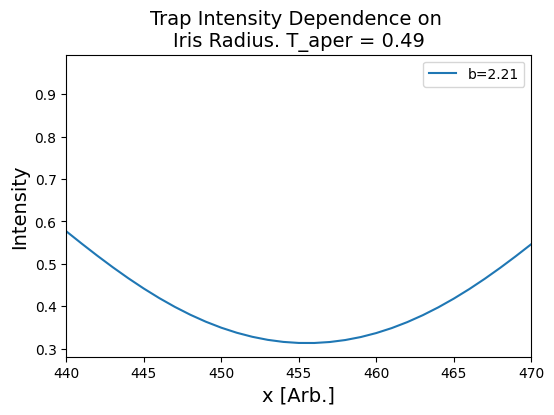

In [171]:
savefig=False
fig,ax = plt.subplots(dpi=100)
for i in [8]:
    ax.plot(range(pts),slices_soln[:,i],label=f'b={b_steps[i]*1e3:0.2f}')
ax.set_title("Trap Intensity Dependence on \nIris Radius. T_aper = 0.49",fontsize=fontsize)
ax.set_xlabel("x [Arb.]",fontsize=fontsize)
ax.set_ylabel("Intensity",fontsize=fontsize)
# ax.set_ylim((0,0.025))
ax.set_xlim((440,470))
ax.legend()
if savefig:
    fname = f"plot_trap_profile_spot_t_plate_{int(100*t_plate)}_T_aper_{int(100*T_aper)}_b_steps_{int(b_steps[0]*1e6)}_{int(b_steps[-1])}um_{numsteps}pts.png"
    savefigure(fname)

In [174]:
# input mask
pts = 1000
phi_std=None # [rad]
pos_std=None

phi = 0
bs = 0.00221
T_aper = 0.49
r_aper = sqrt(1-T) # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

# range of spot phases wrt to background
numsteps = 11
phi_steps = linspace(0,45,numsteps) 
I2max = 1

z2 = f2 # output plane

xslice = 453 # x coordinate of the slice
slices_soln = empty((pts,numsteps),dtype=float)

for i,phi in enumerate(phi_steps):

    # calculate the input field
    print(f'phi={phi}')
    mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
    
#     add phases to input field 
    spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
    spot_phases *= exp(-1j*phi*pi/180)
    phase_mask = spot_phases + complement

#     finally, apply the phases to the transmission mask
    field0 = mask*phase_mask
#     field0 = mask

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding= int(pts/2) 
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,bs,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                              logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2,field1,bs,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)
    
    if phi == 0:
        I2max = max(abs(field2[:,xslice])**2)
        print("obtained normalization factor")
    
    slices_soln[:,i] = abs(field2[:,xslice])**2
    print(f"step {i} completed")
    
# I2max = max(abs(field2[:,xslice])**2)
for i in range(numsteps):
    slices_soln[:,i] /= I2max

phi=0.0
obtained normalization factor
step 0 completed
phi=4.5
step 1 completed
phi=9.0
step 2 completed
phi=13.5
step 3 completed
phi=18.0
step 4 completed
phi=22.5
step 5 completed
phi=27.0
step 6 completed
phi=31.5
step 7 completed
phi=36.0
step 8 completed
phi=40.5
step 9 completed
phi=45.0
step 10 completed


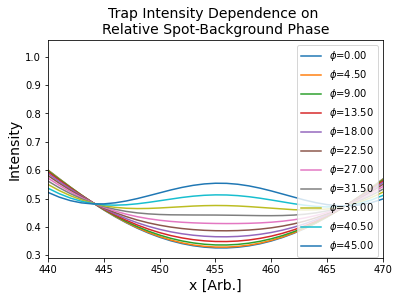

In [179]:
savefig=False
fig,ax = plt.subplots()
for i in range(numsteps):
    ax.plot(range(pts),slices_soln[:,i],label=f'$\phi$={phi_steps[i]:0.2f}')
ax.set_title("Trap Intensity Dependence on \nRelative Spot-Background Phase",fontsize=fontsize)
ax.set_xlabel("x [Arb.]",fontsize=fontsize)
ax.set_ylabel("Intensity",fontsize=fontsize)
# ax.set_ylim((0,0.025))
ax.set_xlim((440,470))
ax.legend()
if savefig:
    fname = f"plot_trap_profile_spot_b_{int(1e6*bs)}us_t_plate_{int(100*t_plate)}_T_aper_{int(100*T_aper)}_phi_steps_{int(phi_steps[0]/pi)}_{int(phi_steps[-1])}_{numsteps}pts.png"
    savefigure(fname)

In [4]:
# input mask
pts = 1000
phi_std=None # [rad]
pos_std=None

phi = 0
bs = 0.00221
T_aper = 0.082
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)

# compute the correct by which to normalize
field0 = mask
# FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
padding= int(pts/2) 
rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
field1,x1pts = lens_xform(f1,field0,bs,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                          logging=False)
# OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
field2,x2pts = lens_xform(z2,field1,bs,f2,k,x1pts,rr1,padding,masked=True,
                          logging=False)
I2max = max(abs(field2[:,xslice])**2) # normalize everything else to this

NameError: name 'xnum1' is not defined

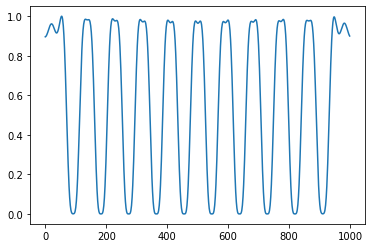

In [200]:
plt.plot(range(pts),abs(field2[:,xslice])**2/max(abs(field2[:,xslice])**2))

In [292]:
# range of spot phases wrt to background
numstepsy = 13
numstepsx = 11
T_aper = 0.49
phi_steps = linspace(100,180,numstepsy) 
b_steps = linspace(0.6*1e-3,1.5*1e-3,numstepsx) 

z2 = f2 # output plane

xslice = 453 # x coordinate of the slice
yslice = 455
slices_soln = empty((pts,numsteps),dtype=float)

soln = empty((numstepsy,numstepsx),float)
for i,phi in enumerate(phi_steps):
    for j,bs in enumerate(b_steps):

        # calculate the input field
#         print(f'phi={phi}')
        mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)

    #     add phases to input field 
        spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
        spot_phases *= exp(-1j*phi*pi/180)
        phase_mask = spot_phases + complement

    #     finally, apply the phases to the transmission mask
        field0 = mask*phase_mask
    #     field0 = mask

        # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
        padding= int(pts/2) 
        rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
        field1,x1pts = lens_xform(f1,field0,bs,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                                  logging=False)

        # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
        rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
        field2,x2pts = lens_xform(z2,field1,bs,f2,k,x1pts,rr1,padding,masked=True,
                                  logging=False)

        soln[i,j] = abs(field2[yslice,xslice])**2
        print(f"step {j + numstepsx*i} completed")
    
# I2max = max(abs(field2[:,xslice])**2)
for i in range(numstepsx):
    slices_soln[:,i] /= I2max

step 0 completed
step 1 completed
step 2 completed
step 3 completed
step 4 completed
step 5 completed
step 6 completed
step 7 completed
step 8 completed
step 9 completed
step 10 completed
step 11 completed
step 12 completed
step 13 completed
step 14 completed
step 15 completed
step 16 completed
step 17 completed
step 18 completed
step 19 completed
step 20 completed
step 21 completed
step 22 completed
step 23 completed
step 24 completed
step 25 completed
step 26 completed
step 27 completed
step 28 completed
step 29 completed
step 30 completed
step 31 completed
step 32 completed
step 33 completed
step 34 completed
step 35 completed
step 36 completed
step 37 completed
step 38 completed
step 39 completed
step 40 completed
step 41 completed
step 42 completed
step 43 completed
step 44 completed
step 45 completed
step 46 completed
step 47 completed
step 48 completed
step 49 completed
step 50 completed
step 51 completed
step 52 completed
step 53 completed
step 54 completed
step 55 completed
st

C:\Users\prest\AppData\Local\Temp/ipykernel_11524/3899164282.py:47: RuntimeWarning: invalid value encountered in true_divide
  slices_soln[:,i] /= I2max


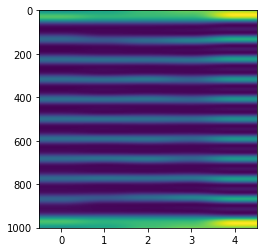

In [26]:
fig,ax = plt.subplots()
ax.imshow(slices_soln)
ax.set_aspect(0.005)

saved file to ..\images\min_T_aper_49_phi_steps_100_180_13pts_b_steps_600_1500um_11pts.png


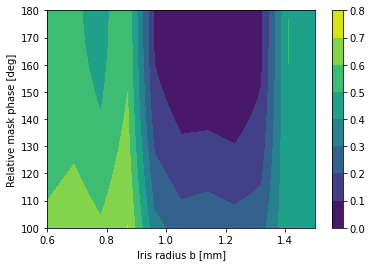

In [293]:
fig,ax = plt.subplots()
cmap = ax.contourf(soln/I2max,extent=[1e3*b_steps[0], 1e3*b_steps[-1], phi_steps[0], phi_steps[-1]]) # left right bottom top
fig.colorbar(cmap)
# ax.set_aspect(.01)
ax.set_xlabel('Iris radius b [mm]')
ax.set_ylabel('Relative mask phase [deg]')

savefigure(f'min_T_aper_{int(100*T_aper)}_phi_steps_{int(phi_steps[0])}_{int(phi_steps[-1])}_{numstepsy}pts_b_steps_{int(b_steps[0]*1e6)}_{int(b_steps[-1]*1e6)}um_{numstepsx}pts.png')

(0.1, 0.7)

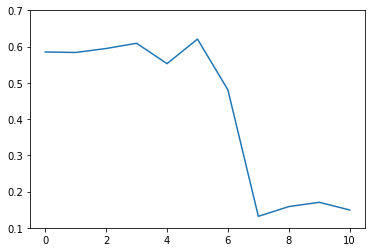

In [291]:
plt.plot(range(numstepsx),soln[-1,:]/I2max)
plt.ylim((0.1,0.7))

In [11]:
# input mask
pts = 1001
phi_std=None # [rad]
pos_std=None

phi = 140
T_aper = 0.49 # a far from optimal reflectivity value
r_aper = sqrt(1-T_aper) # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
complement, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)
spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
spot_phases *= exp(-1j*phi*pi/180)
phase_mask = spot_phases + complement

# range of spot phases wrt to background
numsteps = 5
b_steps = linspace(1e-3,1.3e-3,numsteps)
I2max = 1

z2 = f2 # output plane

xslice = 453 # x coordinate of the slice
slices_soln = empty((pts,numsteps),dtype=float) 

for i,bs in enumerate(b_steps):

    # calculate the input field
    print(f'b={bs*1e3}mm')
    mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=sqrt(T_aper), plate=t_plate)
    
#     add phases to input field 
#     spot_phases, _, _ = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
#     spot_phases *= exp(-1j*phi*pi/180)
#     phase_mask = spot_phases + complement

#     finally, apply the phases to the transmission mask
    field0 = mask*phase_mask

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding= int(3*pts/2) 
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,bs,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                              logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2,field1,bs,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)
    
    if bs == b:
        I2max = max(abs(field2[:,xslice])**2)
        print("obtained normalization factor")
    
    slices_soln[:,i] = abs(field2[:,xslice])**2
    print(f"step {i} completed")
    
I2max = max(abs(field2[:,xslice])**2)
for i in range(numsteps):
    slices_soln[:,i] /= I2max

b=1.0mm
step 0 completed
b=1.075mm
step 1 completed
b=1.15mm
step 2 completed
b=1.2249999999999999mm
step 3 completed
b=1.3mm
step 4 completed


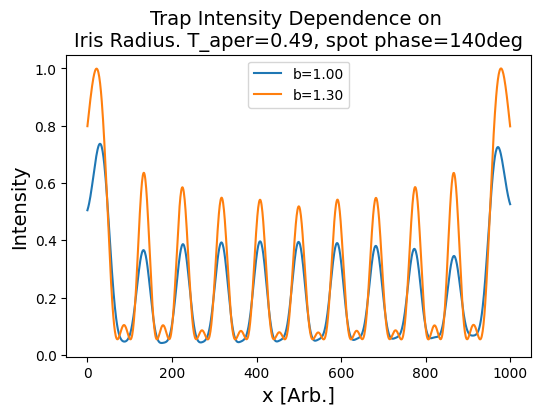

In [12]:
savefig=False
fig,ax = plt.subplots(dpi=100)
for i in [0,-1]:
    ax.plot(range(pts),slices_soln[:,i],label=f'b={b_steps[i]*1e3:0.2f}')
ax.set_title(f"Trap Intensity Dependence on \nIris Radius. T_aper={T_aper}, spot phase={phi}deg",fontsize=fontsize)
ax.set_xlabel("x [Arb.]",fontsize=fontsize)
ax.set_ylabel("Intensity",fontsize=fontsize)
# ax.set_ylim((0,0.025))
# ax.set_xlim((440,470))
ax.legend()
if savefig:
    fname = f"plot_trap_profile_spot_t_plate_{int(100*t_plate)}_phi_{phi}_T_aper_{int(100*T_aper)}_b_steps_{int(b_steps[0]*1e6)}_{int(b_steps[-1])}um_{numsteps}pts.png"
    savefigure(fname)

In [303]:
0.001/b

0.40740136959331485